
<h1> <b> Loading libraries and mounting drive </h1>
---



In [1]:
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h1> <b> Reading image file paths </h1>

In [3]:
base_dir = '/content/drive/Shareddrives/CGR_deep_learning_project/dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir= os.path.join(base_dir, 'validation')

# Create a list with the filepaths for training and testing
train_filepaths = list(Path(train_dir).glob(r'**/*.jpg'))
test_filepaths = list(Path(test_dir).glob(r'**/*.jpg'))
val_filepaths = list(Path(val_dir).glob(r'**/*.jpg'))

<h1> <b> Creating dataframe using labels from folder and image path </h1>

In [4]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

<h1> <b> Exploratory data analysis </h1>

See class imbalances and explore some images from each category

In [5]:
pd.concat([train_df,test_df,val_df])['Label'].value_counts(normalize=True)

soy beans        0.032483
peas             0.031323
spinach          0.031032
lettuce          0.030452
turnip           0.030452
cabbage          0.030162
tomato           0.030162
pineapple        0.030162
beetroot         0.030162
corn             0.030162
sweetcorn        0.029872
garlic           0.029872
kiwi             0.029582
grapes           0.029292
watermelon       0.028712
capsicum         0.028422
cucumber         0.028422
onion            0.028422
jalepeno         0.028132
mango            0.028132
eggplant         0.028132
pear             0.027842
bell pepper      0.027842
pomegranate      0.027262
paprika          0.027262
chilli pepper    0.026102
sweetpotato      0.025812
cauliflower      0.025812
carrot           0.025232
raddish          0.024942
potato           0.024362
ginger           0.024362
banana           0.023202
lemon            0.022622
apple            0.022042
orange           0.021752
Name: Label, dtype: float64

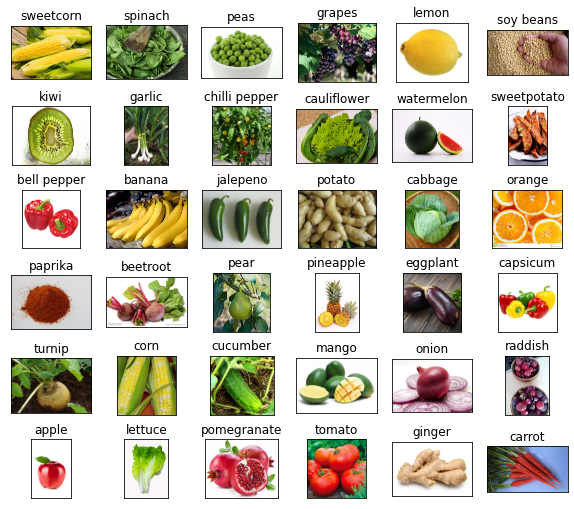

In [6]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [7]:
# # cargamos una InceptionV3
# model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=True,
#                                           input_shape=(299, 299, 3))
# model.summary()
# # descargamos algunas imágenes de ejemplo
# !wget -O koala.jpg https://upload.wikimedia.org/wikipedia/commons/4/49/Koala_climbing_tree.jpg
# #!wget -O wolf.jpg https://kids.nationalgeographic.com/content/dam/kids/photos/animals/Mammals/A-G/gray-wolf-closeup.adapt.945.1.jpg
# !wget -O wolf.jpg https://www.zooportraits.com/wp-content/uploads/2017/03/grey-wolf.jpg
# !wget -O tiger.jpg https://steemit-production-imageproxy-upload.s3.amazonaws.com/DQmenD8j2rha9SkqpB1gQDrkuE9FmjBTwxb4eGbmHQ81aGM
# !wget -O cat.jpg https://as.com/epik/imagenes/2017/11/13/portada/1510586807_350031_1510586958_noticia_normal.jpg

# # cargamos las imágenes
# ims = [tf.keras.preprocessing.image.load_img(i, target_size=(299, 299, 3))\
#        for i in ["koala.jpg", "wolf.jpg", "tiger.jpg", "cat.jpg"]]
# # convertimos las imágenes a arreglos de numpy
# ims = np.array(list(map(np.array, ims)))
# # aplicamos el preprocesamiento de la InceptionV3 a las imágenes
# ims_prep = tf.keras.applications.inception_v3.preprocess_input(ims.copy())
# # mostramos el tamaño de nuestras imágenes
# ims_prep.shape

# # obtenemos las predicciones
# preds = model.predict(ims_prep)
# # obtenemos el nombre de las categorías predichas
# labs = tf.keras.applications.inception_v3.decode_predictions(preds)
# # mostramos las imágenes y las categorías predichas
# fig, ax = plt.subplots(4, 2, figsize=(10,20))
# for i in range(4):
#     ax[i, 0].imshow(ims[i]); ax[i, 0].axis("off")
#     ax[i, 1].bar(list(map(lambda x:x[1], labs[i])),
#                  list(map(lambda x:x[2], labs[i])), color="k")
#     ax[i,1].set_xticklabels(list(map(lambda x:x[1], labs[i])), rotation=45)
# fig.tight_layout()

<h1><b> Create generator from data and transform it </h1>

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


<h1><b> Load pre trained model: mobilnet V2</h1>

In [9]:
# Cargamos mobilenet sin el top (capas densas del final)
extractor = tf.keras.applications.MobileNet(weights='imagenet', include_top=False,
                                            input_shape=(224, 224, 3))
extractor.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [10]:
# Load the pretained model kaggle
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


<h1><b>Add few extra layers and output layer. Train the model </h1>

In [24]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)


Epoch 1/10
13/87 [===>..........................] - ETA: 3:04 - loss: 3.4281 - accuracy: 0.1130

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


87/87 [==============================] - 218s 2s/step - loss: 1.8693 - accuracy: 0.5165 - val_loss: 0.5865 - val_accuracy: 0.8293
Epoch 2/10
87/87 [==============================] - 197s 2s/step - loss: 0.6055 - accuracy: 0.8140 - val_loss: 0.3221 - val_accuracy: 0.8982
Epoch 3/10
87/87 [==============================] - 200s 2s/step - loss: 0.3689 - accuracy: 0.8845 - val_loss: 0.2393 - val_accuracy: 0.9251
Epoch 4/10
87/87 [==============================] - 199s 2s/step - loss: 0.2327 - accuracy: 0.9259 - val_loss: 0.2143 - val_accuracy: 0.9251
Epoch 5/10
87/87 [==============================] - 197s 2s/step - loss: 0.1652 - accuracy: 0.9511 - val_loss: 0.1823 - val_accuracy: 0.9491
Epoch 6/10
87/87 [==============================] - 201s 2s/step - loss: 0.1155 - accuracy: 0.9658 - val_loss: 0.1607 - val_accuracy: 0.9491
Epoch 7/10
87/87 [==============================] - 200s 2s/step - loss: 0.0750 - accuracy: 0.9777 - val_loss: 0.1315 - val_accuracy: 0.9611
Epoch 8/10
87/87 [======

<h1><b> Validate model with accuracy, loss and random examples </h1>

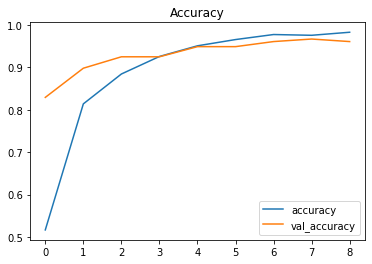

In [25]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

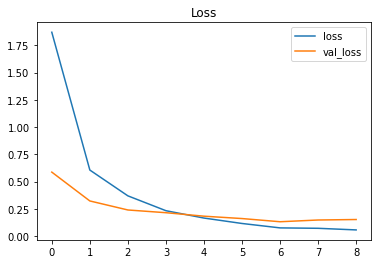

In [26]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [27]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [28]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 96.11%


In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

               precision    recall  f1-score   support

        apple       1.00      0.67      0.80         9
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       0.82      1.00      0.90         9
      cabbage       1.00      1.00      1.00        10
     capsicum       1.00      0.78      0.88         9
       carrot       1.00      1.00      1.00         7
  cauliflower       1.00      1.00      1.00         9
chilli pepper       1.00      1.00      1.00         7
         corn       0.86      0.60      0.71        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00         8
     jalepeno       1.00      1.00      1.00         9
         kiwi       1.00      1.00      1.00        10
        l

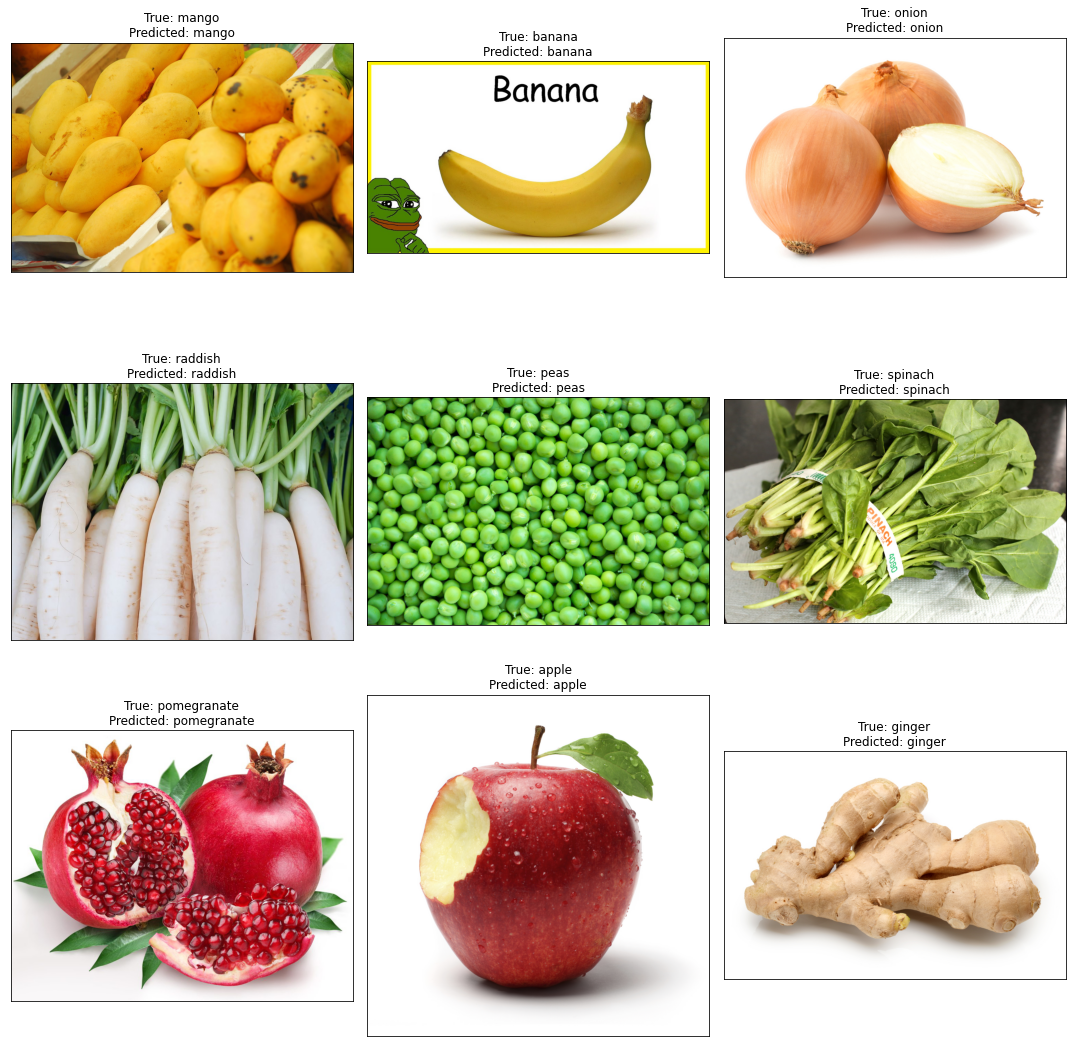

In [30]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [31]:
set(pred)

{'apple',
 'banana',
 'beetroot',
 'bell pepper',
 'cabbage',
 'capsicum',
 'carrot',
 'cauliflower',
 'chilli pepper',
 'corn',
 'cucumber',
 'eggplant',
 'garlic',
 'ginger',
 'grapes',
 'jalepeno',
 'kiwi',
 'lemon',
 'lettuce',
 'mango',
 'onion',
 'orange',
 'paprika',
 'pear',
 'peas',
 'pineapple',
 'pomegranate',
 'potato',
 'raddish',
 'soy beans',
 'spinach',
 'sweetcorn',
 'sweetpotato',
 'tomato',
 'turnip',
 'watermelon'}

<h1> <b> Testing a few random images </h1>

---



In [32]:
!wget -O pera.jpg https://www.collinsdictionary.com/images/full/pear_274360775.jpg

--2022-09-12 16:38:42--  https://www.collinsdictionary.com/images/full/pear_274360775.jpg
Resolving www.collinsdictionary.com (www.collinsdictionary.com)... 104.20.190.42, 172.67.19.203, 104.20.191.42, ...
Connecting to www.collinsdictionary.com (www.collinsdictionary.com)|104.20.190.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 393973 (385K) [image/jpeg]
Saving to: ‘pera.jpg’

pera.jpg            100%[===================>] 384.74K  --.-KB/s    in 0.01s   

2022-09-12 16:38:42 (29.3 MB/s) - ‘pera.jpg’ saved [393973/393973]



In [33]:
# cargamos las imágenes
ims = [tf.keras.preprocessing.image.load_img(i, target_size=(224, 224, 3))\
       for i in ["pera.jpg"]]
# convertimos las imágenes a arreglos de numpy
ims = np.array(list(map(np.array, ims)))
# aplicamos el preprocesamiento de la InceptionV3 a las imágenes
ims_prep = tf.keras.applications.mobilenet_v2.preprocess_input(ims.copy())
# mostramos el tamaño de nuestras imágenes
ims_prep.shape

(1, 224, 224, 3)

In [34]:
# obtenemos las predicciones
preds = np.argmax(model.predict(ims_prep),axis=1)
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
preds = [labels[k] for k in preds]
preds

['pear']

<h2> <b> Images from phone </h2>

In [35]:
# cargamos las imágenes
base_dir="/content/drive/Shareddrives/CGR_deep_learning_project/Imagenes_celular/"
ims = [tf.keras.preprocessing.image.load_img(i, target_size=(224, 224, 3))\
       for i in [base_dir+element for element in os.listdir(base_dir)]]
# convertimos las imágenes a arreglos de numpy
ims = np.array(list(map(np.array, ims)))
# aplicamos el preprocesamiento de la InceptionV3 a las imágenes
ims_prep = tf.keras.applications.mobilenet_v2.preprocess_input(ims.copy())
# mostramos el tamaño de nuestras imágenes
ims_prep.shape
# obtenemos las predicciones
preds = np.argmax(model.predict(ims_prep),axis=1)
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
preds = [labels[k] for k in preds]
preds

['mango', 'peas', 'onion', 'tomato', 'cucumber', 'paprika', 'apple']

In [36]:
os.listdir(base_dir)

['Cebolla1.jpg',
 'Limon1.jpg',
 'Papa1.jpg',
 'Tomate1.jpg',
 'Cohombro2.jpg',
 'Tomate2.jpg',
 'Limon2.jpg']